# Train a CNN

Start from the base opso notebook to see if that stabilizes model training



## Setup

### Import needed packages

In [1]:
# the cnn module provides classes for training/predicting with various types of CNNs
from opensoundscape import CNN

#other utilities and packages
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
import subprocess
from glob import glob
import sklearn
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor_grid

BASE_PATH = Path.cwd().parent.parent
data_path = BASE_PATH / "data"
import sys
sys.path.append(str(BASE_PATH / "src"))

from utils import clean_confidence_cats

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

If you wanted, you could load the training and testing set from these saved CSV files.

In [3]:
train_df = pd.read_pickle(data_path / "interim" / "train_set" / "verified_full_train_set.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

train_df = clean_confidence_cats(train_df)
valid_df = clean_confidence_cats(valid_df)


In [4]:
train_and_val_set = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "train_and_valid_set.pkl")

### Resample data for even class representation

Before training, we will balance the number of samples of each class in the training set. This helps the model learn all of the classes, rather than paying too much attention to the classes with the most labeled annotations. 

In [5]:
from opensoundscape.data_selection import resample

# resample so that all classes have 2000 samples
train_df["target_absence"] = 1 - train_df["target_presence"]
balanced_train_df = resample(train_df,n_samples_per_class=800,random_state=1).sample(frac=1,random_state=0)
balanced_train_df = balanced_train_df[["target_absence", "target_presence"]]

valid_df["target_absence"] = 1 - valid_df["target_presence"]
balanced_valid_df = resample(valid_df,n_samples_per_class=300,random_state=0)
balanced_valid_df = balanced_valid_df[["target_absence", "target_presence"]]

# Drop the redundant absence columns
train_df = train_df[["target_presence"]]
valid_df = valid_df[["target_presence"]]
balanced_train_df = balanced_train_df[["target_presence"]]
balanced_valid_df = balanced_valid_df[["target_presence"]]


In [6]:
balanced_train_df

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-555557.flac,49.5,52.5,0.0
../../data/raw/recordings/OSFL/recording-291495.mp3,18.0,21.0,1.0
../../data/raw/recordings/OSFL/recording-320824.mp3,0.0,3.0,0.0
../../data/raw/recordings/OSFL/recording-826128.flac,13.5,16.5,0.0
../../data/raw/recordings/OSFL/recording-277670.mp3,33.0,36.0,0.0
...,...,...,...
../../data/raw/recordings/OSFL/recording-553428.flac,54.0,57.0,1.0
../../data/raw/recordings/OSFL/recording-40333.mp3,106.5,109.5,0.0
../../data/raw/recordings/OSFL/recording-553491.flac,127.5,130.5,0.0


## Set up model

Now we create a model object. We have to select several parameters when creating this object: its `architecture`, `classes`, and `sample_duration`. 

Some additional parameters can also be changed at this step, such as the preprocessor used to create spectrograms and the shape of the spectrograms. 

For more detail on this step, see the ["Customize CNN training"]("tutorials/CNN.html") tutorial.


### Create CNN object

Now, create a CNN object with this architecture, the classes we put into the dataframe above, and the same sample duration as we selected above.

The first time you run this script for a particular architecture, OpenSoundscape will download the desired architecture.

In [7]:
clip_duration = 3

In [22]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet34 architecture
architecture = "resnet34"

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration = clip_duration
)
model.single_target = False
model.optimizer_params["lr"] = 0.01

# Inspect the input

In [23]:
present_t = train_df.loc[train_df.target_presence == 1]
absent_t = train_df.loc[train_df.target_presence == 0]
present_v = balanced_valid_df.loc[balanced_valid_df.target_presence == 1]
absent_v = balanced_valid_df.loc[balanced_valid_df.target_presence == 0]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([

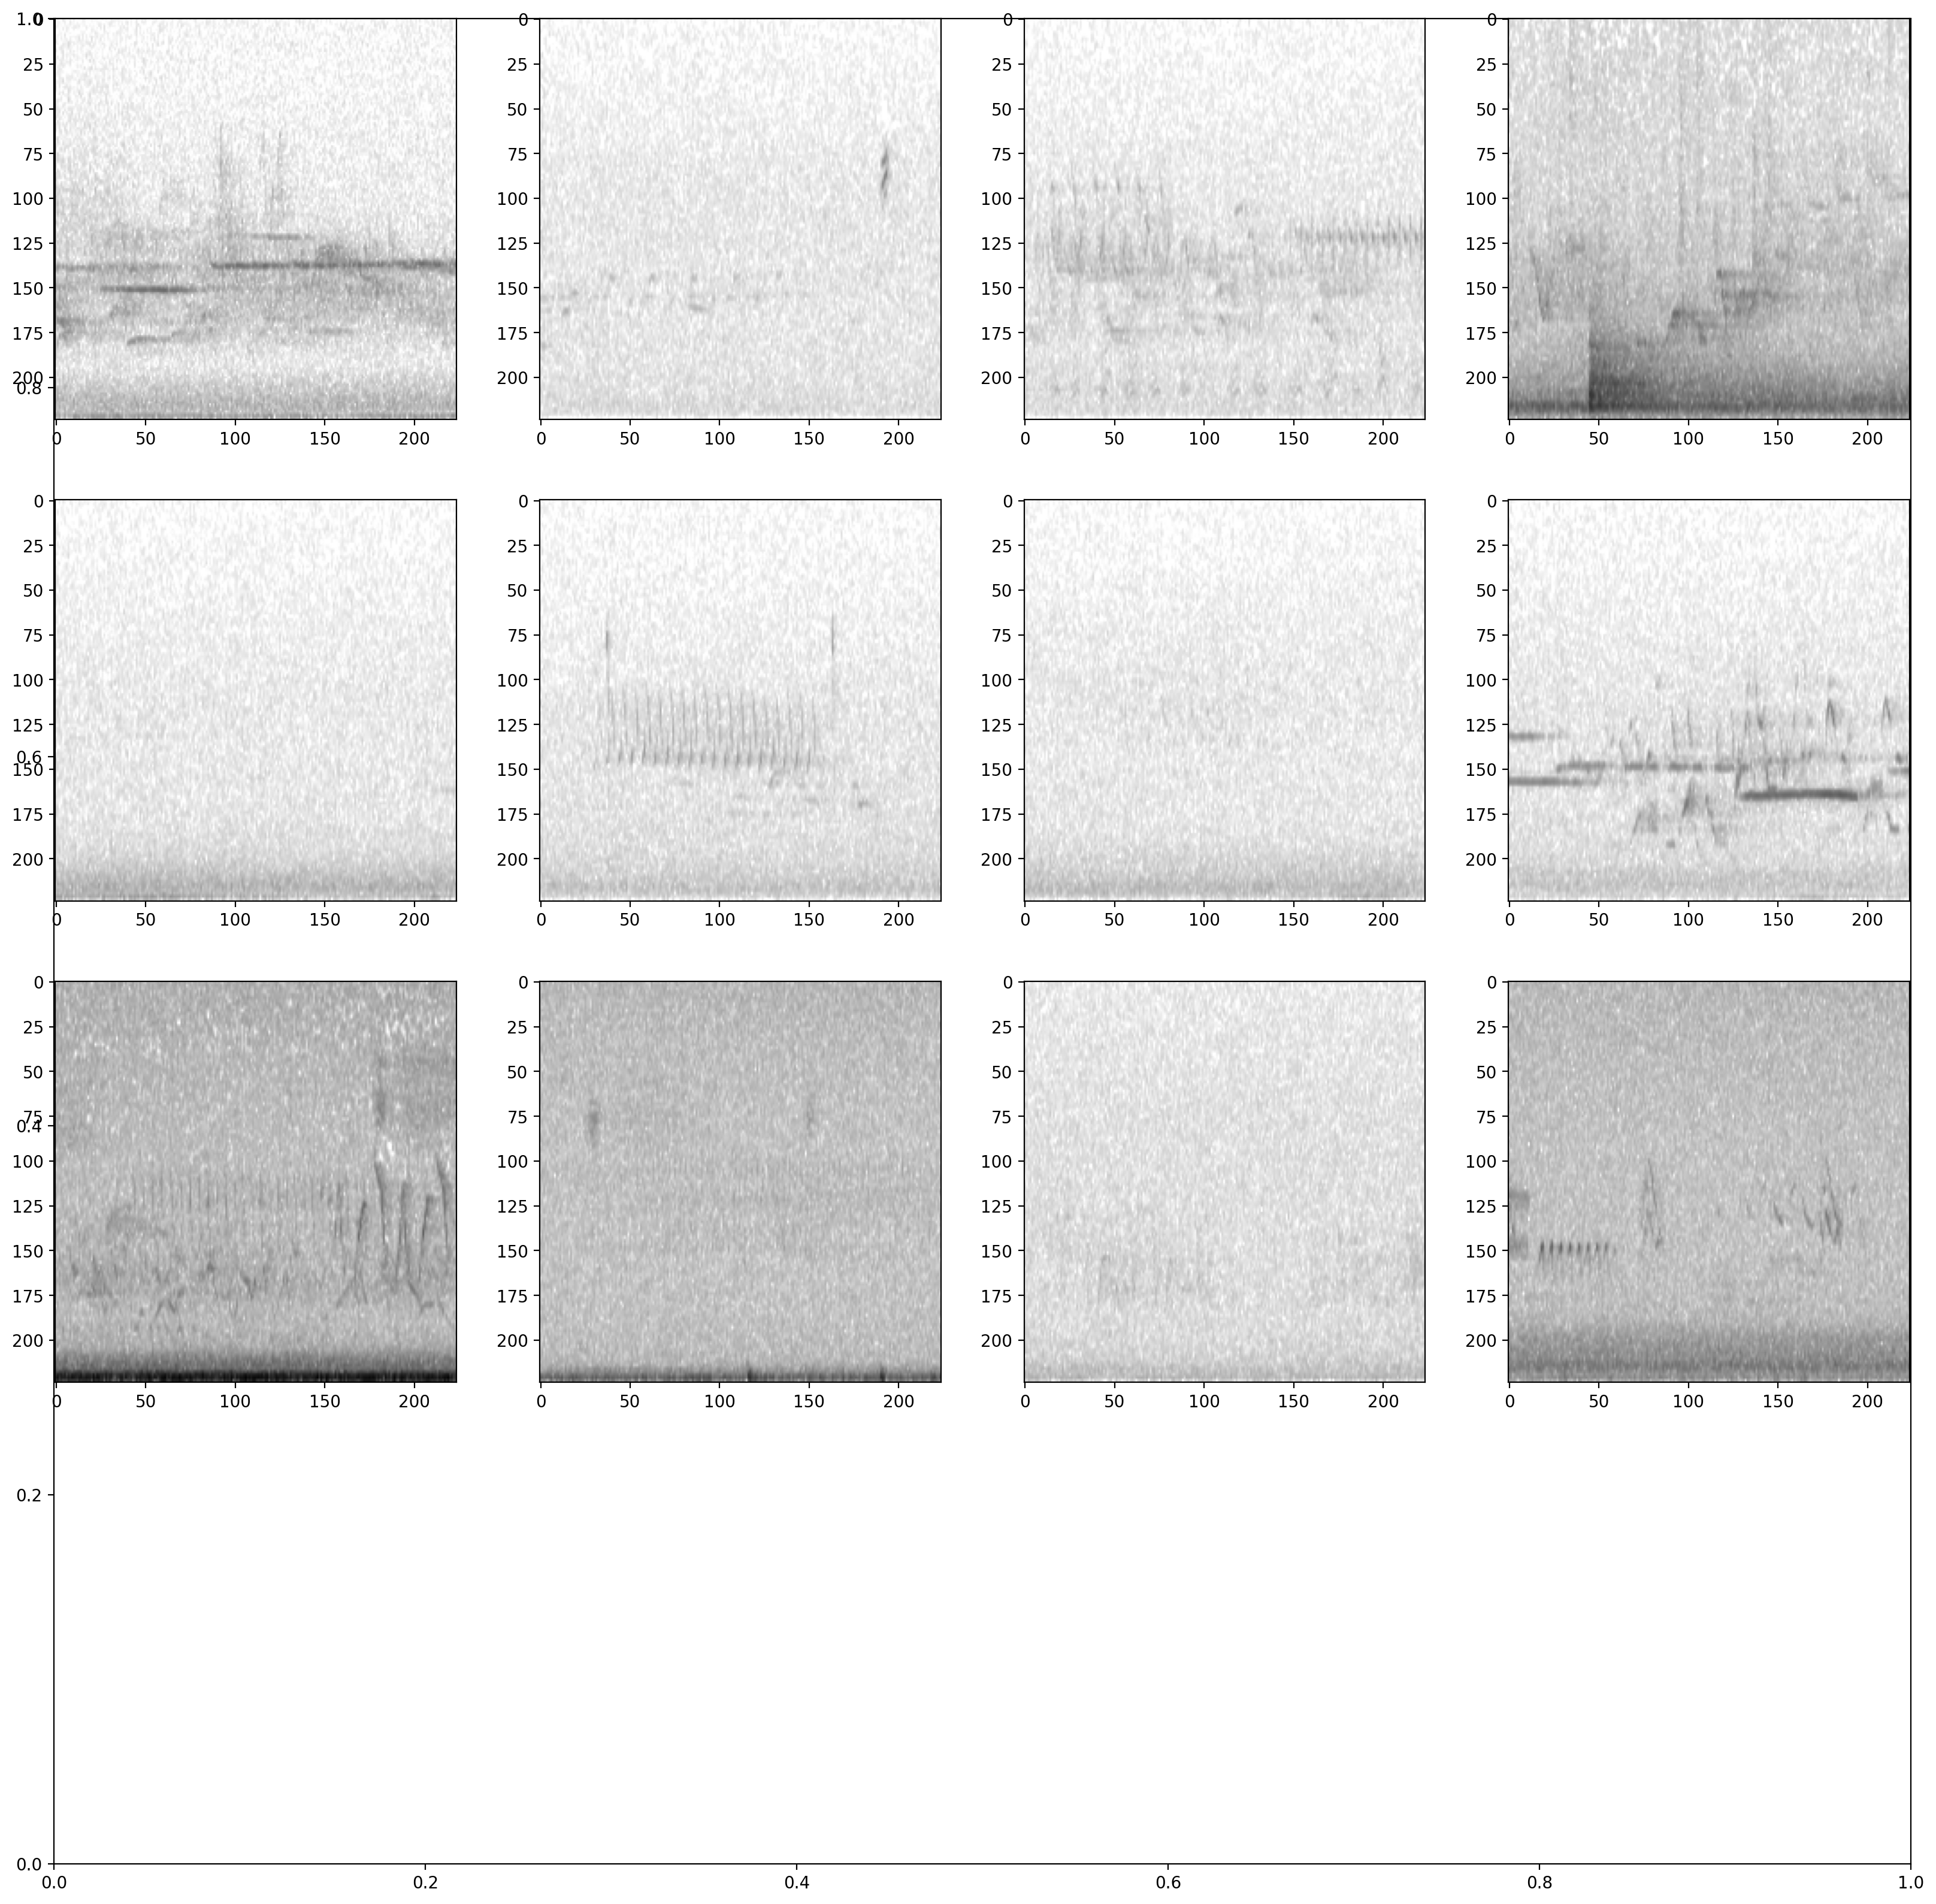

In [24]:
#generate a dataset with the samples we wish to generate and the model's preprocessor
inspection_dataset = opso.AudioFileDataset(absent_t.sample(12), model.preprocessor)
inspection_dataset.bypass_augmentations = True

samples = [sample.data for sample in inspection_dataset]
_ = show_tensor_grid(samples,4,invert=True)

### Check model device

If a GPU is available on your computer, the CNN object automatically selects it for accellerating performance. You can override `.device` to use a specific device such as `cpu` or `cuda:3`

In [25]:
print(f'model.device is: {model.device}')

model.device is: mps


### Set up WandB model logging

While this step is optional, it is very helpful for model training. In this step, we set up model logging on a service called **Weights & Biases** (AKA WandB). 

Weights & Biases is a free website you can use to monitor model training. It is integrated with OpenSoundscape to include helpful functions such as checking on your model's training progress in real time, visualizing the spectrograms created for training your model, comparing multiple tries at training the same model, and more. For more information, check out this [blog post](https://wandb.ai/wandb_fc/repo-spotlight/reports/Community-Spotlight-OpenSoundscape--Vmlldzo0MDcwMTI4). 

The instructions below will help you set up `wandb` logging:

* Create an account on the [Weights and Biases website](https://wandb.ai/). 
* The first time you use `wandb`, you'll need to run `wandb.login()` in Python or `wandb login` on the command line, then enter the API key from your [settings](https://wandb.ai/settings) page
* In a Python script where you want to log model training, use `wandb.init()` as demonstrated below. The "Entity" or team option allows runs and projects to be shared across members in a group, making it easy to collaborate and see progress of other team members' runs.


As training progresses, performance metrics will be plotted to the wandb logging platform and visible on this run's web page. For example, this [wandb web page](https://wandb.ai/kitzeslab/opensoundscape%20training%20demo/runs/w1xyk7zr/workspace?workspace=user-samlapp) shows the content logged to wandb when this notebook was run by the Kitzes Lab. By default, OpenSoundscape + WandB integration creates several pages with information about the model:

- Overview: hyperparameters, run description, and hardware available during the run
- Charts: "Samples" panel with audio and images of preprocessed samples (useful for checking that your preprocessing performs as expected and your labels are correct)
- Charts: graphs of each class's performance metrics over training time
- Model: summary of model architecture
- Logs: standard output of training script
- System: computational performance metrics including memory, CPU use, etc

When training several models and comparing performance, the "Project" page of WandB provides comparisons of metrics and hyperparameters across training runs.

In [26]:
%set_env WANDB_NOTEBOOK_NAME="1.25-start-from-original.ipynb"


env: WANDB_NOTEBOOK_NAME="1.25-start-from-original.ipynb"


In [27]:
import wandb
try:
    wandb.login()
    wandb_session = wandb.init(
        project='osfl',
    )
except: #if wandb.init fails, don't use wandb logging
    print('failed to create wandb session. wandb session will be None')
    wandb_session = None

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.25-start-from-original.ipynb".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


## Train the CNN

Finally, train the CNN for two epoch. Typically, we would train the model for more than two epochs, but because training is slow and is much better done outside of a Jupyter Notebook, we just include this as a short demonstration of training.

Each **epoch** is one pass-through of all of the samples in the training dataset, plus running predictions on the validation dataset. 

Each epoch is composed of smaller groups of samples called **batches**. The machine learning model predicts on every sample in the batch, then the model weights are updated based on those samples. Larger batches can increase training speed, but require more memory. If you get a memory error, try reducing the batch size.

We use default training parameters, but many aspects of CNN training can be customized (see the "Customize CNN training" tutorial for examples).

In [28]:
checkpoint_folder = Path("model_training_checkpoints")
checkpoint_folder.mkdir(exist_ok=True)

training on mps (Apple Silicon GPU) requires PyTorch >= 2.1.0. If we have an older 

In [29]:
#%%capture --no-stdout --no-display
# Uncomment the line above to silence outputs from this cell

model.train(
    balanced_train_df, 
    balanced_valid_df, 
    epochs = 8, 
    batch_size = 64, 
    log_interval = 100, #log progress every 100 batches
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    save_interval = 2, #save checkpoint every 10 epochs
    save_path = checkpoint_folder #location to save checkpoints
)


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.730
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.494

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.772
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.485

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.707
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.508

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 3 [batch 0/25, 0.00%] 
	DistLoss: 0.711
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.490

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 4 [batch 0/25, 0.00%] 
	DistLoss: 0.689
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.508

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 5 [batch 0/25, 0.00%] 
	DistLoss: 0.693
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.492

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 6


  0%|          | 0/25 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 6 [batch 0/25, 0.00%] 
	DistLoss: 0.692
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.481

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Training Epoch 7


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 [batch 0/25, 0.00%] 
	DistLoss: 0.706


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.5859410430839 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
	MAP: 0.509

Validation.


  0%|          | 0/10 [00:00<?, ?it/s]

Metrics:
	MAP: 0.500

Best Model Appears at Epoch 0 with Validation score 0.500.


In [23]:
model.valid_metrics

{0: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 1: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 2: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 3: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 4: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 5: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,
  'jaccard': 0.25,
  'hamming_loss': 0.5},
 6: {'confusion_matrix': array([[600]]),
  'precision': 0.5,
  'recall': 1.0,
  'f1': 0.6666666666666666,


In [21]:
model.predict(balanced_train_df.head())

  0%|          | 0/5 [00:00<?, ?it/s]

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-555557.flac,49.5,52.5,-0.000581
../../data/raw/recordings/OSFL/recording-291495.mp3,18.0,21.0,-0.000581
../../data/raw/recordings/OSFL/recording-320824.mp3,0.0,3.0,-0.000581
../../data/raw/recordings/OSFL/recording-826128.flac,13.5,16.5,-0.000581
../../data/raw/recordings/OSFL/recording-277670.mp3,33.0,36.0,-0.000581


Once this is finished running, you have trained the CNN. 

**Clean up:** Run the following cell to delete the files created in this tutorial. However, these files are used in other tutorials, so you may wish not to delete them just yet.

In [17]:
balanced_train_df.value_counts(), balanced_valid_df.value_counts()

(target_presence
 0.0                800
 1.0                800
 Name: count, dtype: int64,
 target_presence
 0.0                300
 1.0                300
 Name: count, dtype: int64)

In [18]:
model.classes

['target_presence']

In [19]:
import shutil
shutil.rmtree('./annotated_data')
shutil.rmtree('./wandb')
shutil.rmtree('./model_training_checkpoints')
Path('annotation_Files.zip').unlink()
Path('mp3_Files.zip').unlink()

FileNotFoundError: [Errno 2] No such file or directory: './annotated_data'